In [54]:
import pandas as pd
import numpy as np
import os
import subprocess

### Mapillary counts

In [55]:
img_ct = pd.read_csv("../../../data/tag_counts/germany_image_counts.csv")
img_ct.image_count.sum()

169994544

about 170M images in Germany (query data Nov. 2023)

### Mercantile tiles

In [60]:
meta = pd.read_csv("../../../data/v5/train_tiles_metadata.csv")

In [61]:
len(meta)

51457123

5.1M images in search space of V5.

In [66]:
round(len(meta) / img_ct.image_count.sum(), 3)

0.303

30% sample in V5 as image search space.

In [67]:
meta["date"] = pd.to_datetime(meta.captured_at,  unit="ms")

In [68]:
meta["year"] = pd.to_datetime(meta.captured_at,  unit="ms").dt.year

In [69]:
meta.value_counts("year").sort_index()

year
1899           9
1921           4
1970          96
1980         459
1994          18
2000           2
2002        1299
2004          48
2005           5
2006         849
2007         320
2008        1405
2009        2129
2010        3010
2011        7734
2012       11964
2013        9228
2014      620403
2015     1203190
2016     2040851
2017     2915628
2018     3688915
2019     5432688
2020     8348287
2021    10028970
2022     8821842
2023     8060625
2024      257145
Name: count, dtype: int64

In [70]:
# take out date outliers (any dates before launch date 2013)
meta[meta["captured_at"] > 1363074956000]["date"].describe()

count                         51427459
mean     2020-10-04 19:29:34.389486848
min                2013-03-16 13:35:26
25%                2019-06-23 16:25:13
50%      2021-03-17 12:41:47.158000128
75%         2022-06-12 10:46:37.500000
max                2024-01-16 16:12:56
Name: date, dtype: object

In [71]:
len(meta[meta["captured_at"] < 1394610956000])

43222

In [72]:
np.percentile(meta[meta["captured_at"] > 1363074956000]["date"], 50)

numpy.datetime64('2021-03-17T12:41:47.158000000')

<Axes: >

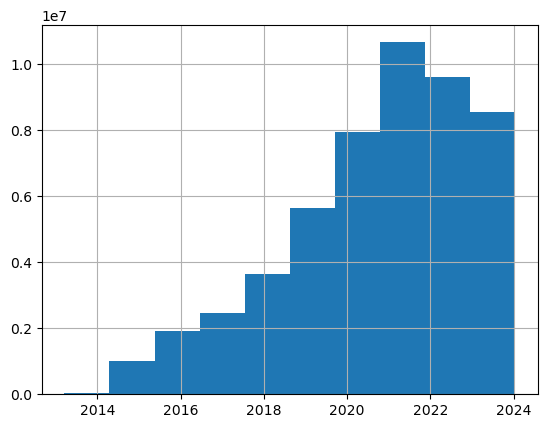

In [73]:
meta[meta["captured_at"] > 1363074956000]["date"].hist()

In [79]:
len(df_V4)

1799

## creator names

In [82]:
!curl 'https://graph.mapillary.com/148771344320493?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/293245499014573?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/133978728960378?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/129178263353193?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/291493615899057?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/828495164980463?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/137193541781677?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/149787357161377?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'

{"id":"148771344320493","creator":{"username":"macsico","id":"108354611399818"}}{"id":"293245499014573","creator":{"username":"zoegglmeyr","id":"110552844504419"}}{"id":"133978728960378","creator":{"username":"carlheinz","id":"100232345559807"}}{"id":"129178263353193","creator":{"username":"carlheinz","id":"100232345559807"}}{"id":"291493615899057","creator":{"username":"hubert87","id":"102532525320329"}}{"id":"828495164980463","creator":{"username":"carlheinz","id":"100232345559807"}}{"id":"137193541781677","creator":{"username":"waldemar","id":"110655437834109"}}{"id":"149787357161377","creator":{"username":"rasmustravemnd","id":"107765738126751"}}

## Precision of OSMT and TCM

In [83]:

def clean_smoothness(metadata):
    """Clean smoothness column of metadata dataframe according to defined OSM smoothness values

    Args:
        metadata (df): dataframe with image metadata, including column "smoothness"

    Returns:
        df: dataframe with cleaned smoothness column "smoothness_clean"
    """
    metadata["smoothness"] = metadata.smoothness.str.strip()
    metadata["smoothness_clean"] = metadata["smoothness"].replace(
        [
            "horrible",
            "very_horrible",
            "impassable",
            "very bad"
        ],
        "very_bad",
    )

    metadata["smoothness_clean"] = metadata["smoothness_clean"].replace(
        ["perfect", "very_good"], "excellent"
    )
    return metadata


def clean_surface(metadata):
    """Clean surface column of metadata dataframe according to defined OSM surface values

    Args:
        metadata (df): dataframe with image metadata, including column "surface"

    Returns:
        df: dataframe with cleaned surface column "surface_clean"
    """
    metadata["surface"] = metadata.surface.str.strip()
    metadata["surface_clean"] = metadata["surface"].replace(
        [
            "compacted",
            "gravel",
            "ground",
            "fine_gravel",
            "dirt",
            "grass",
            "earth",
            "sand",
        ],
        "unpaved",
    )
    metadata["surface_clean"] = metadata["surface_clean"].replace(
        ["cobblestone", "cobblestone:flattened", "unhewn_cobblestone"], "sett"
    )
    metadata["surface_clean"] = metadata["surface_clean"].replace(
        ["concrete:plates", "concrete:lanes"], "concrete",
    )
    return metadata

In [84]:
smoothness_mapping = {"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5}

In [85]:
# osm frequency distribution
osm_tag_counts = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/OSM/osm_tag_counts_germany.csv")
osm_tag_counts.surface = osm_tag_counts.surface.str.strip()
osm_tag_counts.smoothness = osm_tag_counts.smoothness.str.strip()
osm_tag_counts = clean_surface(osm_tag_counts)
osm_tag_counts = clean_smoothness(osm_tag_counts)
osm_tag_counts.rename({"surface_clean": "surface_osm", "smoothness_clean": "smoothness_osm"}, axis=1, inplace=True)
osm_tag_counts["smoothness_osm_int"] = osm_tag_counts.smoothness_osm.map(smoothness_mapping)

# compute distr.
osm_tag_counts["osm_distr"] = round(osm_tag_counts.ct / osm_tag_counts.ct.sum() * 100, 2)

# remove irrelevant classes 
osm_tag_counts = osm_tag_counts[~osm_tag_counts.surface_osm.isin(["pebblestone", "wood","grass_paver", "metal"])]


In [99]:
# annotations
annotations = pd.read_csv("../../../data/v12/annotations_combined.csv", index_col=False, dtype={"image_id": str})
annotations.loc[annotations.nostreet.notna(), "surface"] = "nostreet"
annotations.loc[annotations.nostreet.notna(), "smoothness"] = "nostreet"


In [100]:
# intersected osm tags
osm_tags = pd.read_csv("../../../data/v5_mapillary_metadata_with_tags_NEW.csv", dtype={"id": str})
osm_tags= clean_surface(osm_tags)
osm_tags =  clean_smoothness(osm_tags)
osm_tags.rename({"surface_clean": "surface_osm", "smoothness_clean": "smoothness_osm"}, axis=1, inplace=True)
osm_tags["smoothness_osm_int"] = osm_tags.smoothness_osm.map(smoothness_mapping)



In [101]:
# get all classification model predictions
cloud_image_folder = (
    "/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/"
)
model_prediction_path = os.path.join(cloud_image_folder, "training", "{}", "metadata")
model_prediction_file = {
    "V5_c1": "model_predictions_V5_c1_predicted.csv",
    "V5_c2": "surface_prediction-V5_c2-20240215_143635.csv",
    "V5_c3": "surface_prediction-V5_c3-20240222_122429.csv",
    "V5_c4": "surface_prediction-V5_c4-20240226_150406.csv",
    "V5_c5": "surface_prediction-V5_c5-20240226_155720.csv",
    "V5_c6": "surface_prediction-V5_c6-20240305_171454.csv",
    "V5_c7": "surface_prediction-V5_c7-20240306_100314.csv",
}

tcm_pred = pd.DataFrame()
for pred_file in model_prediction_file.items():
    temp = pd.read_csv(os.path.join(model_prediction_path.format(pred_file[0]), pred_file[1]), dtype={"Image": str, "image_id": str})
    temp.rename({"Image": "image_id", "Prediction": "class_probability", "Level_0":"model_prediction"}, axis=1, inplace=True)
    idx = temp.groupby("image_id")["class_probability"].idxmax()
    temp = temp.loc[idx]
    tcm_pred = pd.concat([tcm_pred,temp])

In [102]:
df = (annotations[["image_id", "surface", "smoothness"]]
.set_index("image_id")
.join(osm_tags[["id", "surface_osm", "smoothness_osm_int", "smoothness_osm"]].set_index("id"), how="outer")
)

df["smoothness_int"] = df.smoothness.map(smoothness_mapping)

# only keep images where we have a classification model prediction
df = df.join(tcm_pred.set_index("image_id"), how="right")

# remove all instances where we do not have a new OSM tag
df = df[df.surface_osm.notna()]
df = df[df.smoothness_osm.notna()]

In [103]:
def osmt_precisions(df, osm_tag_counts, group_by_annot, group_by_osm):
    if group_by_annot == ["surface"]:
        # drop uncleaned columns
        drop_col = ["surface", "smoothness", "smoothness_osm"]
        # on how many tags do annotations and prediction agree (true positives)?
        tp = pd.DataFrame(df[(df.surface == df.surface_osm) &
                            (df.model_prediction == df.surface_osm)].groupby(group_by_annot).size())
    else:
        drop_col = ["surface", "smoothness"]
        tp = pd.DataFrame(df[(df.surface == df.surface_osm) & 
                            (df.model_prediction == df.surface_osm) &
                            (df.smoothness == df.smoothness_osm)].groupby(group_by_annot).size())
    osm_tag_counts = osm_tag_counts.drop(drop_col, axis=1).groupby(group_by_osm).sum()
    tp.columns = ["tp"]

    # how many images did we classify by the model? # group by OSM Tag counts 
    TCM_classified = pd.DataFrame(df.groupby(group_by_osm).size())
    TCM_classified.columns = ["TCM_classified"]

    # on how many tags do OSMT and TCM agree (how many are annotated) that also have (any) annotation?
    annotated = pd.DataFrame(df[(df.model_prediction == df.surface_osm) &
                                df.surface.notna()].groupby(group_by_osm).size())
    annotated.columns = ["annotated"]

    cts = (tp
    .join(osm_tag_counts["osm_distr"], on=group_by_annot, how="left")
    .join(TCM_classified, on=group_by_annot, how="outer")
    .join(annotated, on=group_by_annot, how="outer")
    )

    cts["OSMT: tp/TCM_classified"] = round(cts.tp / cts.TCM_classified * 100, 2)
    cts["OSMT+CTM: tp/annotated"] = round(cts.tp / cts.annotated * 100, 2)
    cts.sort_index(inplace=True)
    return(cts)

In [104]:
group_by_annot = ["surface", "smoothness_int", "smoothness"]
group_by_osm = ["surface_osm", "smoothness_osm_int", "smoothness_osm"]
cts = osmt_precisions(df, osm_tag_counts, group_by_annot, group_by_osm)
cts

tp  osm_distr  TCM_classified  \
surface       smoothness_int smoothness                                       
asphalt       1.0            excellent     123.0      20.31             442   
              2.0            good          147.0      29.29             515   
              3.0            intermediate  353.0       4.05            2396   
              4.0            bad            94.0       0.69            1667   
concrete      1.0            excellent      47.0       0.36            1112   
              2.0            good          104.0       0.94             446   
              3.0            intermediate  107.0       0.78             479   
              4.0            bad            32.0       0.23             351   
paving_stones 1.0            excellent     300.0       2.98            2761   
              2.0            good           70.0      10.62             456   
              3.0            intermediate   79.0       1.94            2586   
              4.0            bad             8.0       0.22             797   
sett          2.0            good           31.0       0.56            1418   
              3.0            intermediate   98.0       1.97             506   
              4.0            bad           306.0       1.26            2568   
unpaved       2.0            good            NaN        NaN               5   
              3.0            intermediate  140.0       5.75             399   
              4.0            bad           105.0       7.67             367   
              5.0            very_bad       89.0       7.38             476   

                                           annotated  OSMT: tp/TCM_classified  \
surface       smoothness_int smoothness                                         
asphalt       1.0            excellent           283                    27.83   
              2.0            good                293                    28.54   
              3.0            intermediate       1738                    14.73   
              4.0            bad                1068                     5.64   
concrete      1.0            excellent           165                     4.23   
              2.0            good                189                    23.32   
              3.0            intermediate        240                    22.34   
              4.0            bad                 156                     9.12   
paving_stones 1.0            excellent           991                    10.87   
              2.0            good                151                    15.35   
              3.0            intermediate        794                     3.05   
              4.0            bad                 209                     1.00   
sett          2.0            good                240                     2.19   
              3.0            intermediate        205                    19.37   
              4.0            bad                 656                    11.92   
unpaved       2.0            good                  1                      NaN   
              3.0            intermediate        230                    35.09   
              4.0            bad                 235                    28.61   
              5.0            very_bad            331                    18.70   

                                           OSMT+CTM: tp/annotated  
surface       smoothness_int smoothness                            
asphalt       1.0            excellent                      43.46  
              2.0            good                           50.17  
              3.0            intermediate                   20.31  
              4.0            bad                             8.80  
concrete      1.0            excellent                      28.48  
              2.0            good                           55.03  
              3.0            intermediate                   44.58  
              4.0            bad                            20.51  
pavi

In [105]:
cts.TCM_classified.sum()

19747

In [106]:
cts.reset_index(inplace=True)

In [107]:
# all classes
cts["class"] = cts.surface + "-" + cts.smoothness
print(
    cts.loc[:, 
            ["class", "osm_distr", "OSMT: tp/TCM_classified", "OSMT+CTM: tp/annotated"]]
    .to_latex(float_format="%.2f", index=False)
)

\begin{tabular}{lrrr}
\toprule
class & osm_distr & OSMT: tp/TCM_classified & OSMT+CTM: tp/annotated \\
\midrule
asphalt-excellent & 20.31 & 27.83 & 43.46 \\
asphalt-good & 29.29 & 28.54 & 50.17 \\
asphalt-intermediate & 4.05 & 14.73 & 20.31 \\
asphalt-bad & 0.69 & 5.64 & 8.80 \\
concrete-excellent & 0.36 & 4.23 & 28.48 \\
concrete-good & 0.94 & 23.32 & 55.03 \\
concrete-intermediate & 0.78 & 22.34 & 44.58 \\
concrete-bad & 0.23 & 9.12 & 20.51 \\
paving_stones-excellent & 2.98 & 10.87 & 30.27 \\
paving_stones-good & 10.62 & 15.35 & 46.36 \\
paving_stones-intermediate & 1.94 & 3.05 & 9.95 \\
paving_stones-bad & 0.22 & 1.00 & 3.83 \\
sett-good & 0.56 & 2.19 & 12.92 \\
sett-intermediate & 1.97 & 19.37 & 47.80 \\
sett-bad & 1.26 & 11.92 & 46.65 \\
unpaved-good & NaN & NaN & NaN \\
unpaved-intermediate & 5.75 & 35.09 & 60.87 \\
unpaved-bad & 7.67 & 28.61 & 44.68 \\
unpaved-very_bad & 7.38 & 18.70 & 26.89 \\
\bottomrule
\end{tabular}



In [108]:
# selection for paper
cts["class"] = cts.surface + "-" + cts.smoothness
print(
    cts.loc[cts.surface.isin(["asphalt", "paving_stones"]), 
            ["class", "osm_distr", "OSMT: tp/TCM_classified", "OSMT+CTM: tp/annotated"]]
    .to_latex(float_format="%.2f", index=False)
)

\begin{tabular}{lrrr}
\toprule
class & osm_distr & OSMT: tp/TCM_classified & OSMT+CTM: tp/annotated \\
\midrule
asphalt-excellent & 20.31 & 27.83 & 43.46 \\
asphalt-good & 29.29 & 28.54 & 50.17 \\
asphalt-intermediate & 4.05 & 14.73 & 20.31 \\
asphalt-bad & 0.69 & 5.64 & 8.80 \\
paving_stones-excellent & 2.98 & 10.87 & 30.27 \\
paving_stones-good & 10.62 & 15.35 & 46.36 \\
paving_stones-intermediate & 1.94 & 3.05 & 9.95 \\
paving_stones-bad & 0.22 & 1.00 & 3.83 \\
\bottomrule
\end{tabular}



In [109]:
group_by_annot = ["surface"]
group_by_osm = ["surface_osm"]
cts = osmt_precisions(df, osm_tag_counts, group_by_annot, group_by_osm)
cts

,tp,osm_distr,TCM_classified,annotated,OSMT: tp/TCM_classified,OSMT+CTM: tp/annotated
surface,,,,,,
asphalt,2207,54.42,5020,3382,43.96,65.26
concrete,553,2.32,2388,750,23.16,73.73
paving_stones,1265,15.78,6600,2145,19.17,58.97
sett,796,4.05,4492,1101,17.72,72.30
unpaved,554,22.14,1247,797,44.43,69.51


### Precision of overall surface type for OSM-tag + pseudo-label approach

"OSM labels and manual annotation agreed on 68\% of surface type labels, and among these, the quality was correct for 53\% of the images."
 > See "anlayze_prediction_V4.ipynb"

In [110]:
# for OSM pre-label + pseudo-label

# precision, when **including** nostreet
valid_img = df[(df.model_prediction == df.surface_osm) &
            (df.surface.notna()) ]

annotated = valid_img.groupby(group_by_osm).size()

tp = valid_img[
            (valid_img.surface == valid_img.model_prediction)].groupby(group_by_osm).size()

prec_surface_only_valid = pd.DataFrame({"tp": tp}).join(pd.DataFrame({"annot": annotated}))
total = prec_surface_only_valid.sum()
prec_surface_only_valid = pd.concat([prec_surface_only_valid, pd.DataFrame({"mean": total}).T])
prec_surface_only_valid["prec"] = prec_surface_only_valid.tp / prec_surface_only_valid.annot
#tp / len (df[(df.surface != "nostreet") & df.surface.notna()])
prec_surface_only_valid

,tp,annot,prec
asphalt,2207,3382,0.652572
concrete,553,750,0.737333
paving_stones,1265,2145,0.589744
sett,796,1101,0.722979
unpaved,554,797,0.695107
mean,5375,8175,0.657492


In [111]:
# for OSM pre-label + pseudo-label
# precision, when **removing** nostreet
valid_img = df[(df.surface != "nostreet") &
            (df.model_prediction == df.surface_osm) &
            (df.surface.notna()) ]

annotated = valid_img.groupby(group_by_osm).size()

tp = valid_img[
            (valid_img.surface == valid_img.surface_osm) &
            (valid_img.model_prediction == valid_img.surface_osm)].groupby(group_by_osm).size()

prec_surface_only_valid = pd.DataFrame({"tp": tp}).join(pd.DataFrame({"annot": annotated}))
total = prec_surface_only_valid.sum()
prec_surface_only_valid = pd.concat([prec_surface_only_valid, pd.DataFrame({"mean": total}).T])
prec_surface_only_valid["prec"] = prec_surface_only_valid.tp / prec_surface_only_valid.annot
#tp / len (df[(df.surface != "nostreet") & df.surface.notna()])
prec_surface_only_valid

,tp,annot,prec
asphalt,2207,2225,0.991910
concrete,553,588,0.940476
paving_stones,1265,1416,0.893362
sett,796,834,0.954436
unpaved,554,557,0.994614
mean,5375,5620,0.956406


In [112]:
prec_surface_only_valid[prec_surface_only_valid.index != "mean"].prec.mean()

0.9549596678373276

## Datapool size

In [ ]:
# how many images in entire datapool V101
v100 = pd.read_csv("../../../data/v100/train_tiles_selection.csv", index_col=False)
v100["tile_id"] = [str(x) + "_" + str(y) + "_14" for x, y in zip(v100["x"], v100["y"])]

In [223]:
v5 = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/train_tiles_selection.csv", index_col=False)
v5["tile_id"] = [str(x) + "_" + str(y) + "_14" for x, y in zip(v5["x"], v5["y"])]

In [224]:
v5_selection = pd.read_csv("../../../data/v5/train_image_selection_metadata.csv", index_col=False)

In [225]:
v5x = v5[~v5.tile_id.isin(v5_selection.tile_id)]

In [228]:
sum(v100.image_count) + sum(v5x.image_count)

21369848

## Image sizes per class

In [2]:
v1point0 = pd.read_csv("../../../data/mapillary_images/V1_0/streetSurfaceVis_v1_0.csv")


# split by train / test
v1point0["train_"] = ""
v1point0.loc[v1point0.train, "train_"] = "0"
v1point0.loc[v1point0.train == False, "train_"] = "1"
summary = (v1point0
    .groupby(["surface_type", "surface_quality", "train_"]).size()
    .unstack("surface_quality", fill_value=0)

    .reindex(columns=["excellent", "good", "intermediate", "bad", "very_bad"])
    .unstack("train_", fill_value=0)
    .droplevel(1, axis=1)
    )

summary_table = pd.DataFrame()
summary_table.index = summary.index
summary_table["excellent"] = summary.iloc[:, 0].astype(str) + " (" + summary.iloc[:, 1].astype(str) + ")"
summary_table["good"] = summary.iloc[:, 2].astype(str) + " (" + summary.iloc[:, 3].astype(str) + ")"
summary_table["intermediate"] = summary.iloc[:, 4].astype(str) + " (" + summary.iloc[:, 5].astype(str) + ")"
summary_table["bad"] = summary.iloc[:, 6].astype(str) + " (" + summary.iloc[:, 7].astype(str) + ")"
summary_table["very_bad"] = summary.iloc[:, 8].astype(str) + " (" + summary.iloc[:, 9].astype(str) + ")"
print(summary_table.to_latex())

\begin{tabular}{llllll}
\toprule
 & excellent & good & intermediate & bad & very_bad \\
surface_type &  &  &  &  &  \\
\midrule
asphalt & 791 (180) & 1407 (289) & 768 (53) & 238 (8) & 0 (0) \\
concrete & 310 (4) & 340 (10) & 248 (2) & 58 (0) & 0 (0) \\
paving_stones & 360 (25) & 989 (74) & 505 (14) & 70 (0) & 0 (0) \\
sett & 0 (0) & 128 (1) & 677 (17) & 526 (14) & 0 (0) \\
unpaved & 0 (0) & 0 (0) & 305 (21) & 339 (48) & 287 (16) \\
\bottomrule
\end{tabular}



In [3]:
summary_table

,excellent,good,intermediate,bad,very_bad
surface_type,,,,,
asphalt,791 (180),1407 (289),768 (53),238 (8),0 (0)
concrete,310 (4),340 (10),248 (2),58 (0),0 (0)
paving_stones,360 (25),989 (74),505 (14),70 (0),0 (0)
sett,0 (0),128 (1),677 (17),526 (14),0 (0)
unpaved,0 (0),0 (0),305 (21),339 (48),287 (16)


In [36]:
summary = (v1point0
    .groupby(["surface_type", "surface_quality"]).size()
    .unstack("surface_quality", fill_value=0)
    .reindex(columns=["excellent", "good", "intermediate", "bad", "very_bad"])
    )

print(summary.to_latex())

\begin{tabular}{lrrrrr}
\toprule
surface_quality & excellent & good & intermediate & bad & very_bad \\
surface_type &  &  &  &  &  \\
\midrule
asphalt & 971 & 1696 & 821 & 246 & 0 \\
concrete & 314 & 350 & 250 & 58 & 0 \\
paving_stones & 385 & 1063 & 519 & 70 & 0 \\
sett & 0 & 129 & 694 & 540 & 0 \\
unpaved & 0 & 0 & 326 & 387 & 303 \\
\bottomrule
\end{tabular}



In [37]:
#summary

In [39]:
len(v1point0)

9122

In [38]:
v1point0.groupby([ "train"]).size()

train
False     776
True     8346
dtype: int64

### V12 numbers

In [33]:
v12 = pd.read_csv("../../../data/v12/metadata/annotations_combined.csv", index_col=False, dtype={"image_id": str})

v12.groupby(["surface", "smoothness"]).size()

surface        smoothness  
asphalt        bad              123
               excellent        783
               good            1334
               intermediate     623
concrete       bad               54
               excellent        189
               good             340
               intermediate     249
paving_stones  bad               31
               excellent        342
               good             693
               intermediate     197
sett           bad              518
               good              99
               intermediate     659
unpaved        bad              336
               intermediate     305
               very_bad         158
dtype: int64